In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/amazon_sale_report.csv')
df = pd.DataFrame(data)
print(df.columns)

Index(['index', 'Order ID', 'Date', 'Status', 'Fulfilment', 'Sales Channel ',
       'ship-service-level', 'Style', 'SKU', 'Category', 'Size', 'ASIN',
       'Courier Status', 'Qty', 'currency', 'Amount', 'ship-city',
       'ship-state', 'ship-postal-code', 'ship-country', 'promotion-ids',
       'B2B', 'fulfilled-by', 'Unnamed: 22'],
      dtype='object')


<ipython-input-2-b1eec17a78af>:1: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/amazon_sale_report.csv')


In [ ]:
#dropping unnecessary columns
df_cleaned = df.drop(columns=['index', 'Order ID', 'Date', 'SKU', 'ASIN', 'ship-postal-code',
                              'promotion-ids', 'fulfilled-by', 'Unnamed: 22'])
df_cleaned = df_cleaned.dropna()
#One-hot encoding categorical columns like 'ship-city', 'Category', 'Status', etc.
df_encoded = pd.get_dummies(df_cleaned, columns=['ship-city', 'Category', 'Status', 'ship-state', 'ship-country', 'Fulfilment', 'Sales Channel ', 'ship-service-level'], drop_first=True)

In [ ]:
#numerical features: 'Amount' and 'Qty', along with the encoded categorical features
X = df_encoded[['Amount', 'Qty'] + [col for col in df_encoded.columns if col not in ['Amount', 'Qty']]]

#normalizing numerical features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[['Amount', 'Qty']])

In [ ]:
#K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_cleaned['Cluster'] = kmeans.fit_predict(X_scaled)

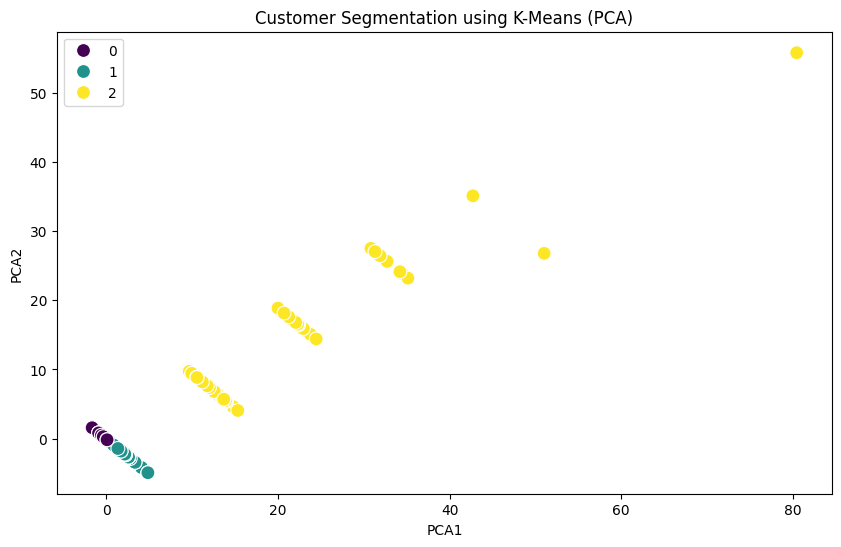

In [ ]:
#PCA Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

#Adding PCA results to the DataFrame
df_cleaned['PCA1'] = X_pca[:, 0]
df_cleaned['PCA2'] = X_pca[:, 1]

#plotting the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df_cleaned, palette='viridis', s=100)
plt.title("Customer Segmentation using K-Means (PCA)")
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

In [ ]:
df_cleaned.groupby('Cluster')[['Amount', 'Qty']].mean()

,Amount,Qty
Cluster,,
0,477.721843,1.000000
1,934.027838,1.000000
2,1291.701847,2.155673


In [ ]:
pd.crosstab(df_cleaned['Cluster'], df_cleaned['Category'], normalize='index')

Category,Blouse,Bottom,Dupatta,Ethnic Dress,Saree,Set,Top,Western Dress,kurta
Cluster,,,,,,,,,
0,0.010514,0.005333,0.000041,0.005099,0.000634,0.250844,0.122535,0.034024,0.570976
1,0.001602,0.000046,0.000000,0.015719,0.002299,0.621314,0.021871,0.264337,0.072812
2,0.013193,0.010554,0.000000,0.007916,0.007916,0.306069,0.079156,0.102902,0.472296


In [ ]:
#Cancellation Analysis
df_cancellation = df.copy()

In [ ]:
#binary column for cancellation status(1 for cancelled, 0 for fulfilled/shipped)
df_cancellation['is_cancelled'] = df_cancellation['Status'].apply(lambda x: 1 if 'Cancelled' in x else 0)

In [ ]:
#Comparing cancelled vs. fulfilled orders
print("\nCancellation Rate by Category:")
print(df_cancellation.groupby('Category')['is_cancelled'].mean().sort_values(ascending=False))


Cancellation Rate by Category:
Category
Set              0.145911
kurta            0.145458
Western Dress    0.136903
Bottom           0.136364
Saree            0.128049
Blouse           0.125270
Ethnic Dress     0.125108
Top              0.120128
Dupatta          0.000000
Name: is_cancelled, dtype: float64


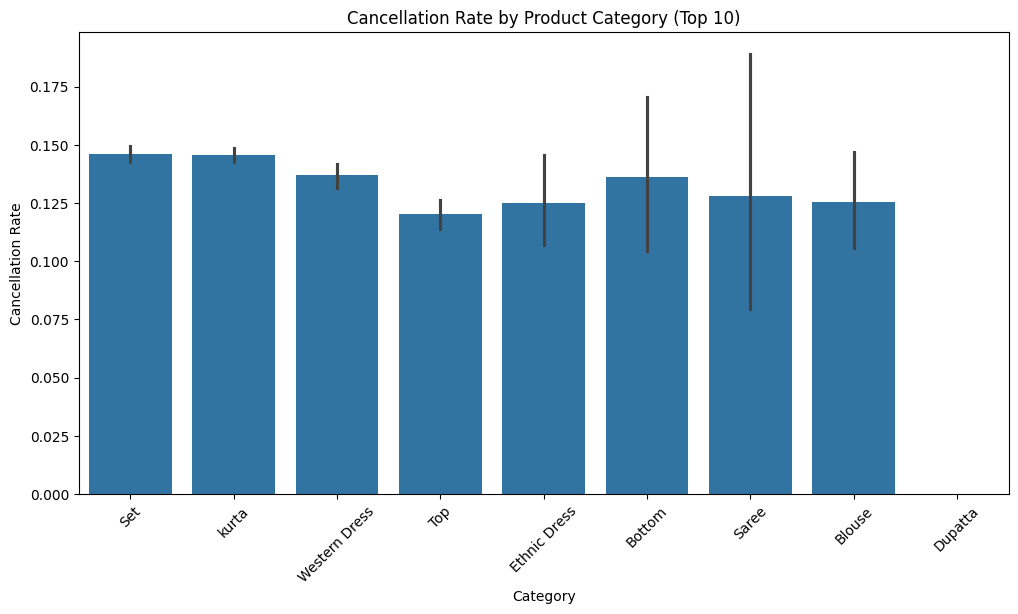

In [ ]:
# Cancellation rate by category (top 10)
top_categories = df_cancellation['Category'].value_counts().index[:10]
plt.figure(figsize=(12, 6))
sns.barplot(x='Category', y='is_cancelled',
            data=df_cancellation[df_cancellation['Category'].isin(top_categories)])
plt.title('Cancellation Rate by Product Category (Top 10)')
plt.xticks(rotation=45)
plt.ylabel('Cancellation Rate')
plt.show()

In [ ]:
print("\nCancellation Rate by State:")
print(df_cancellation.groupby('ship-state')['is_cancelled'].mean().sort_values(ascending=False).head(10))


Cancellation Rate by State:
ship-state
APO                   1.000000
Meghalaya             1.000000
Arunachal Pradesh     0.333333
Rajshthan             0.333333
LAKSHADWEEP           0.250000
Odisha                0.238095
MIZORAM               0.186667
HIMACHAL PRADESH      0.185279
KERALA                0.178436
ANDAMAN & NICOBAR     0.175097
Name: is_cancelled, dtype: float64


In [ ]:
print("\nAverage Order Amount by Cancellation Status:")
print(df_cancellation.groupby('is_cancelled')['Amount'].mean())


Average Order Amount by Cancellation Status:
is_cancelled
0    649.133208
1    642.697780
Name: Amount, dtype: float64


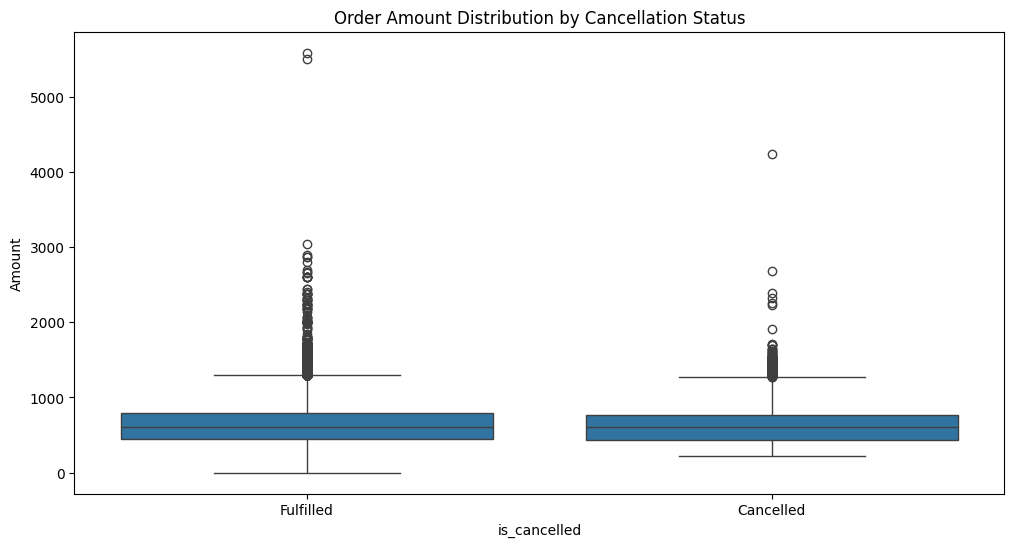

In [ ]:
# Visualizations for comparison
plt.figure(figsize=(12, 6))
sns.boxplot(x='is_cancelled', y='Amount', data=df_cancellation)
plt.title('Order Amount Distribution by Cancellation Status')
plt.xticks([0, 1], ['Fulfilled', 'Cancelled'])
plt.show()

In [ ]:
#Checking correlations with cancellation
#Discounts/promotions
df_cancellation['has_promotion'] = df_cancellation['promotion-ids'].notna().astype(int)
print("\nCancellation Rate by Promotion Presence:")
print(df_cancellation.groupby('has_promotion')['is_cancelled'].mean())


Cancellation Rate by Promotion Presence:
has_promotion
0    0.366956
1    0.003696
Name: is_cancelled, dtype: float64


In [ ]:
#Fulfillment method
print("\nCancellation Rate by Fulfillment Method:")
print(df_cancellation.groupby('Fulfilment')['is_cancelled'].mean())


Cancellation Rate by Fulfillment Method:
Fulfilment
Amazon      0.127885
Merchant    0.174682
Name: is_cancelled, dtype: float64


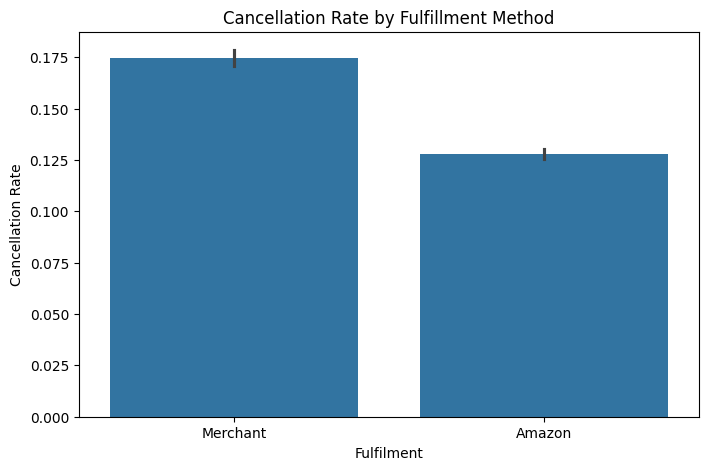

In [ ]:
#Cancellation rate by fulfillment method
plt.figure(figsize=(8, 5))
sns.barplot(x='Fulfilment', y='is_cancelled', data=df_cancellation)
plt.title('Cancellation Rate by Fulfillment Method')
plt.ylabel('Cancellation Rate')
plt.show()

In [ ]:
#Logistic Regression to predict cancellations
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
#Select relevant features
model_data = df_cancellation[['is_cancelled', 'Amount', 'Qty', 'Fulfilment', 'Category', 'ship-state', 'has_promotion']].copy()
model_data = model_data.dropna()

In [ ]:
#One-hot encode categorical variables
model_data = pd.get_dummies(model_data, columns=['Fulfilment', 'Category', 'ship-state'], drop_first=True)

#splitting into features and target
X = model_data.drop('is_cancelled', axis=1)
y = model_data['is_cancelled']

#splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
#training logistic regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

#evaluating model
y_pred = logreg.predict(X_test)
print("\nLogistic Regression Performance:")
print(classification_report(y_test, y_pred))


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     33094
           1       1.00      0.51      0.67      3251

    accuracy                           0.96     36345
   macro avg       0.97      0.75      0.82     36345
weighted avg       0.96      0.96      0.95     36345



In [ ]:
#Feature importance
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': logreg.coef_[0]})
coefficients['Absolute_Coefficient'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values('Absolute_Coefficient', ascending=False)
print("\nFeature Importance for Cancellation Prediction:")
print(coefficients.head(10))


Feature Importance for Cancellation Prediction:
                   Feature  Coefficient  Absolute_Coefficient
2            has_promotion    -7.334167              7.334167
1                      Qty    -5.215537              5.215537
3      Fulfilment_Merchant     1.184779              1.184779
25        ship-state_Delhi    -1.153105              1.153105
39      ship-state_MANIPUR     0.930434              0.930434
40    ship-state_MEGHALAYA     0.850667              0.850667
41      ship-state_MIZORAM     0.801318              0.801318
38  ship-state_MAHARASHTRA    -0.791219              0.791219
45     ship-state_NAGALAND     0.702992              0.702992
10  Category_Western Dress     0.678203              0.678203
